<a href="https://colab.research.google.com/github/gan1014/Machine_learning-projects/blob/main/newface_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install cmake
!pip install dlib
!pip install face-recognition
!pip install opencv-python-headless
!pip install pillow

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import os

drive_dataset_path = '/content/drive/MyDrive/dataset'

print(f"🔍 Checking contents of: {drive_dataset_path}\n")

if os.path.exists(drive_dataset_path):
    print(f"✅ Folder '{drive_dataset_path}' found!\n")
    contents = os.listdir(drive_dataset_path)
    if contents:
        print("Contents:\n")
        for item in contents:
            item_path = os.path.join(drive_dataset_path, item)
            if os.path.isdir(item_path):
                print(f"   📁 {item}/")
            else:
                print(f"   📄 {item}")
    else:
        print("   Folder is empty.")
else:
    print(f"❌ Folder '{drive_dataset_path}' NOT found!")
    print("   Please ensure you have a 'dataset' folder directly in your Google Drive's MyDrive.")

print("\n" + "=" * 60)

🔍 Checking contents of: /content/drive/MyDrive/dataset

✅ Folder '/content/drive/MyDrive/dataset' found!

Contents:

   📁 gan/
   📁 mani/
   📁 ham/
   📁 deep/
   📁 ak/



This check is specifically for the `dataset` folder within your Google Drive's `MyDrive`. The earlier check in Cell 1 (`mv-lxG1KcKCQ`) was for a `dataset` folder located in the local Colab environment's root directory.

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# Cell 1: Check uploaded files

import os

print("🔍 Checking uploaded files...\n")

# Check if dataset folder exists
if os.path.exists("dataset"):
    print("✅ 'dataset' folder found!\n")

    # List all people in dataset
    people = [d for d in os.listdir("dataset") if os.path.isdir(os.path.join("dataset", d))]

    if people:
        print(f"📊 Found {len(people)} people in dataset:\n")

        for person in people:
            person_path = os.path.join("dataset", person)
            images = [f for f in os.listdir(person_path)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            print(f"   👤 {person}:")
            print(f"      Total images: {len(images)}")

            if len(images) < 3:
                print(f"      ⚠️  Warning: Only {len(images)} images. Add at least 3!")
            else:
                print(f"      ✅ Good! {len(images)} images found")

            for img in images:
                print(f"         - {img}")
            print()
    else:
        print("❌ No person folders found inside 'dataset'!")
        print("   Create folders like: dataset/harish/, dataset/minnu/")
else:
    print("❌ 'dataset' folder NOT found!")
    print("   Please upload it using the folder upload button on the left")

print("-" * 60)

# Check test_images folder
if os.path.exists("test_images"):
    print("\n✅ 'test_images' folder found!\n")

    test_images = [f for f in os.listdir("test_images")
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    print(f"   Total test images: {len(test_images)}")
    for img in test_images:
        print(f"      - {img}")
else:
    print("\n❌ 'test_images' folder NOT found!")
    print("   Please upload it")

print("\n" + "=" * 60)

if os.path.exists("dataset") and people and os.path.exists("test_images"):
    print("✅ Everything looks good! Ready to proceed!")
else:
    print("⚠️  Please fix the issues above before continuing")



🔍 Checking uploaded files...

❌ 'dataset' folder NOT found!
   Please upload it using the folder upload button on the left
------------------------------------------------------------

❌ 'test_images' folder NOT found!
   Please upload it

⚠️  Please fix the issues above before continuing


In [30]:
# Cell 2: Install libraries (ONLY RUN ONCE)

print("📦 Installing required libraries...")
print("This will take 1-2 minutes...\n")

!pip install -q cmake
!pip install -q dlib
!pip install -q face-recognition
!pip install -q opencv-python-headless
!pip install -q pillow

print("\n✅ All libraries installed successfully!")
print("✅ Ready to start face recognition!")

📦 Installing required libraries...
This will take 1-2 minutes...


✅ All libraries installed successfully!
✅ Ready to start face recognition!


In [31]:
# Cell 3: Face Recognition System

import face_recognition
import numpy as np
from PIL import Image, ImageDraw
import os
import matplotlib.pyplot as plt
import pickle # Added import for pickle

class SimpleFaceRecognition:
    def __init__(self):
        self.known_faces = []
        self.known_names = []

    def load_training_data(self, dataset_path="dataset", save_path="/content/drive/MyDrive/face_recognition_data"):
        """Load all training images or load from saved pickle files"""
        print("📚 Loading training data...")
        print("-" * 60)

        # Define pickle file paths
        known_faces_file = os.path.join(save_path, "known_faces.pkl")
        known_names_file = os.path.join(save_path, "known_names.pkl")

        # Try to load from pickle files first
        if os.path.exists(known_faces_file) and os.path.exists(known_names_file):
            try:
                print("Attempting to load trained data from pickle files...")
                with open(known_faces_file, 'rb') as f:
                    self.known_faces = pickle.load(f)
                with open(known_names_file, 'rb') as f:
                    self.known_names = pickle.load(f)
                print("✅ Successfully loaded trained data from pickle files!")
                print(f"📊 Total: {len(self.known_faces)} images loaded")
                print(f"👥 People: {', '.join(set(self.known_names))}")
                print("=" * 60 + "\n")
                return True
            except Exception as e:
                print(f"❌ Error loading pickle files: {e}. Re-processing images...")
                # Fallback to image processing if pickle loading fails
        else:
            print("Pickle files not found. Processing images from dataset...")

        total_loaded = 0

        # Loop through each person's folder
        for person_name in os.listdir(dataset_path):
            person_folder = os.path.join(dataset_path, person_name)

            if not os.path.isdir(person_folder):
                continue

            print(f"\n👤 Loading: {person_name}")
            loaded_count = 0

            # Loop through images
            for image_file in os.listdir(person_folder):
                if not image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue

                image_path = os.path.join(person_folder, image_file)

                try:
                    # Load image
                    img = face_recognition.load_image_file(image_path)

                    # Get face encoding
                    encodings = face_recognition.face_encodings(img)

                    if len(encodings) > 0:
                        self.known_faces.append(encodings[0])
                        self.known_names.append(person_name)
                        loaded_count += 1
                        total_loaded += 1
                        print(f"   ✅ {image_file}")
                    else:
                        print(f"   ⚠️  {image_file} - No face found")

                except Exception as e:
                    print(f"   ❌ {image_file} - Error: {e}")

            print(f"   Total: {loaded_count} images loaded for {person_name}")

        print("\n" + "=" * 60)
        print(f"✅ Training complete!")
        print(f"📊 Total: {total_loaded} images loaded")
        print(f"👥 People: {', '.join(set(self.known_names))}")
        print("=" * 60 + "\n")

        # Save the trained data to pickle files if processing was successful
        if total_loaded > 0:
            print(f"💾 Saving trained data to {save_path}...")
            os.makedirs(save_path, exist_ok=True) # Ensure directory exists
            try:
                with open(known_faces_file, 'wb') as f:
                    pickle.dump(self.known_faces, f)
                with open(known_names_file, 'wb') as f:
                    pickle.dump(self.known_names, f)
                print("✅ Trained data saved successfully!")
            except Exception as e:
                print(f"❌ Error saving trained data to pickle files: {e}")

        return total_loaded > 0

    def recognize_image(self, image_path):
        """Recognize faces in an image"""
        print(f"\n🔍 Analyzing: {image_path}")
        print("-" * 60)

        # Load test image
        test_img = face_recognition.load_image_file(image_path)

        # Find faces
        face_locations = face_recognition.face_locations(test_img)
        face_encodings = face_recognition.face_encodings(test_img, face_locations)

        print(f"👥 Found {len(face_locations)} face(s)\n")

        # Convert to PIL for drawing
        pil_img = Image.fromarray(test_img)
        draw = ImageDraw.Draw(pil_img)

        results = []

        # Check each face
        for i, (face_location, face_encoding) in enumerate(zip(face_locations, face_encodings), 1):

            # Compare with known faces
            matches = face_recognition.compare_faces(self.known_faces, face_encoding, tolerance=0.5)
            distances = face_recognition.face_distance(self.known_faces, face_encoding)

            name = "Unknown"
            confidence = 0

            if len(distances) > 0 and True in matches:
                best_match_idx = np.argmin(distances)
                if matches[best_match_idx]:
                    name = self.known_names[best_match_idx]
                    confidence = (1 - distances[best_match_idx]) * 100

            # Draw box
            top, right, bottom, left = face_location
            color = "green" if name != "Unknown" else "red"

            draw.rectangle([(left, top), (right, bottom)], outline=color, width=3)
            draw.rectangle([(left, bottom - 35), (right, bottom)], fill=color)

            text = f"{name} ({confidence:.0f}%)" if name != "Unknown" else "Unknown"
            draw.text((left + 6, bottom - 30), text, fill="white")

            # Print result
            status = "✅" if name != "Unknown" else "❌"
            print(f"{status} Face {i}: {name}", end="")
            if confidence > 0:
                print(f" (Confidence: {confidence:.1f}%)")
            else:
                print()

            results.append({"name": name, "confidence": confidence})

        # Show image
        print("\n" + "=" * 60)
        plt.figure(figsize=(12, 8))
        plt.imshow(pil_img)
        plt.axis('off')
        plt.title("Face Recognition Result", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

        return results

# Create system
print("🚀 Creating Face Recognition System...")
fr = SimpleFaceRecognition()
print("✅ System ready!")

🚀 Creating Face Recognition System...
✅ System ready!


In [32]:
# Cell 4: Load training data

success = fr.load_training_data("/content/drive/MyDrive/dataset", save_path="/content/drive/MyDrive/face_recognition_data")

if success:
    print("🎉 Ready to recognize faces!")
else:
    print("❌ Failed to load data. Check your dataset folder.")

📚 Loading training data...
------------------------------------------------------------
Attempting to load trained data from pickle files...
✅ Successfully loaded trained data from pickle files!
📊 Total: 17 images loaded
👥 People: mani, deep, gan, ak, ham

🎉 Ready to recognize faces!



🔍 Analyzing: /content/drive/MyDrive/test_image/WhatsApp Image 2026-01-22 at 7.18.32 AM.jpeg
------------------------------------------------------------
👥 Found 3 face(s)

✅ Face 1: gan (Confidence: 54.1%)
✅ Face 2: deep (Confidence: 68.4%)
✅ Face 3: ham (Confidence: 57.1%)



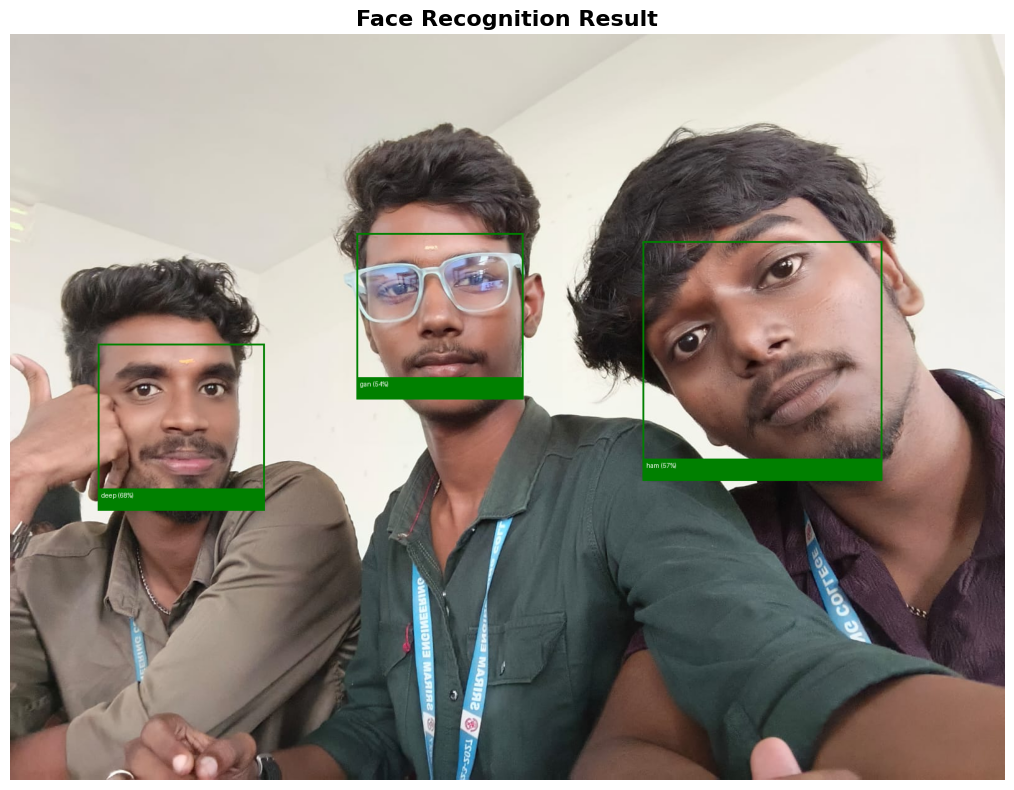


📋 FINAL SUMMARY:
✅ Person 1: gan (54.1% confident)
✅ Person 2: deep (68.4% confident)
✅ Person 3: ham (57.1% confident)


In [33]:
# Cell 5: Recognize faces in test image

# Change this to youtest_images/group_photo.jpgr test image name
test_image = "/content/drive/MyDrive/test_image/WhatsApp Image 2026-01-22 at 7.18.32 AM.jpeg"

results = fr.recognize_image(test_image)

print("\n📋 FINAL SUMMARY:")
print("=" * 60)
for i, result in enumerate(results, 1):
    status = "✅" if result['name'] != "Unknown" else "❌"
    print(f"{status} Person {i}: {result['name']}", end="")
    if result['confidence'] > 0:
        print(f" ({result['confidence']:.1f}% confident)")
    else:
        print()
print("=" * 60)

In [55]:
# Cell 1: Install all required libraries

print("📦 Installing libraries...")
print("This may take 2-3 minutes...\n")

# Install face recognition libraries
!pip install -q cmake
!pip install -q dlib
!pip install -q face-recognition
!pip install -q opencv-python-headless
!pip install -q pillow

# Install Streamlit and dependencies
!pip install -q streamlit
!pip install -q pyngrok

# Install data handling libraries
!pip install -q pandas
!pip install -q openpyxl
!pip install -q plotly

print("\n✅ All libraries installed successfully!")

📦 Installing libraries...
This may take 2-3 minutes...


✅ All libraries installed successfully!


In [35]:
# Cell 2: Check dataset

import os

print("📁 Current files structure:\n")

# Check dataset
if os.path.exists("/content/drive/MyDrive/dataset"):
    print("✅ 'dataset' folder found")
    people = [d for d in os.listdir("/content/drive/MyDrive/dataset") if os.path.isdir(os.path.join("/content/drive/MyDrive/dataset", d))]
    print(f"   People in database: {len(people)}")
    for person in people:
        images = len([f for f in os.listdir(f"/content/drive/MyDrive/dataset/{person}") if f.endswith(('.jpg', '.jpeg', '.png'))])
        print(f"   - {person}: {images} images")
else:
    print("❌ Please upload 'dataset' folder first!")

print()

# Create directories for our system
os.makedirs("attendance_records", exist_ok=True)
os.makedirs("temp_uploads", exist_ok=True)

print("✅ Created necessary directories:")
print("   - attendance_records/ (for storing attendance)")
print("   - temp_uploads/ (for temporary files)")

📁 Current files structure:

✅ 'dataset' folder found
   People in database: 5
   - gan: 5 images
   - mani: 5 images
   - ham: 4 images
   - deep: 5 images
   - ak: 4 images

✅ Created necessary directories:
   - attendance_records/ (for storing attendance)
   - temp_uploads/ (for temporary files)


In [36]:
# Cell 3: Face Recognition + Attendance System

import face_recognition
import numpy as np
from PIL import Image, ImageDraw
import pandas as pd
from datetime import datetime
import os
import json

class AttendanceSystem:
    def __init__(self, dataset_path="/content/drive/MyDrive/dataset", attendance_path="attendance_records"):
        """Initialize the attendance system"""
        self.dataset_path = dataset_path
        self.attendance_path = attendance_path
        self.known_faces = []
        self.known_names = []

        # Create attendance directory
        os.makedirs(attendance_path, exist_ok=True)

        # Current session info
        self.current_session = None
        self.session_attendees = set()

        print("🎓 Attendance System Initialized")

    def load_training_data(self):
        """Load all training images from dataset"""
        print("\n📚 Loading training data...")
        print("-" * 60)

        total_loaded = 0

        if not os.path.exists(self.dataset_path):
            print(f"❌ Dataset path '{self.dataset_path}' not found!")
            return False

        # Loop through each person's folder
        for person_name in os.listdir(self.dataset_path):
            person_folder = os.path.join(self.dataset_path, person_name)

            if not os.path.isdir(person_folder):
                continue

            print(f"\n👤 Loading: {person_name}")
            loaded_count = 0

            # Loop through images
            for image_file in os.listdir(person_folder):
                if not image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue

                image_path = os.path.join(person_folder, image_file)

                try:
                    # Load and encode face
                    img = face_recognition.load_image_file(image_path)
                    encodings = face_recognition.face_encodings(img)

                    if len(encodings) > 0:
                        self.known_faces.append(encodings[0])
                        self.known_names.append(person_name)
                        loaded_count += 1
                        total_loaded += 1
                        print(f"   ✅ {image_file}")
                    else:
                        print(f"   ⚠️  {image_file} - No face detected")

                except Exception as e:
                    print(f"   ❌ {image_file} - Error: {str(e)}")

            print(f"   Total for {person_name}: {loaded_count} images")

        print("\n" + "=" * 60)
        print(f"✅ Training complete!")
        print(f"📊 Total images loaded: {total_loaded}")
        print(f"👥 People in system: {len(set(self.known_names))}")
        print(f"   {', '.join(set(self.known_names))}")
        print("=" * 60 + "\n")

        return total_loaded > 0

    def start_session(self, session_name=None):
        """Start a new attendance session"""
        if session_name is None:
            session_name = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

        self.current_session = session_name
        self.session_attendees = set()

        print(f"📝 Started new session: {session_name}")
        return session_name

    def mark_attendance(self, name, confidence, image_path=None):
        """Mark attendance for a person"""
        if self.current_session is None:
            self.start_session()

        # Check if already marked in this session
        if name in self.session_attendees:
            return False, "Already marked present in this session"

        # Create attendance record
        timestamp = datetime.now()

        record = {
            "name": name,
            "session": self.current_session,
            "date": timestamp.strftime("%Y-%m-%d"),
            "time": timestamp.strftime("%H:%M:%S"),
            "timestamp": timestamp.strftime("%Y-%m-%d %H:%M:%S"),
            "confidence": f"{confidence:.2f}%",
            "image_path": image_path
        }

        # Save to CSV
        csv_file = os.path.join(self.attendance_path, "attendance.csv")
        df = pd.DataFrame([record])

        if os.path.exists(csv_file):
            df.to_csv(csv_file, mode='a', header=False, index=False)
        else:
            df.to_csv(csv_file, index=False)

        # Add to session attendees
        self.session_attendees.add(name)

        return True, "Attendance marked successfully"

    def recognize_and_mark(self, image_path, tolerance=0.5, mark_attendance_flag=True):
        """Recognize faces and optionally mark attendance"""
        print(f"\n🔍 Analyzing: {os.path.basename(image_path)}")
        print("-" * 60)

        # Load image
        test_img = face_recognition.load_image_file(image_path)

        # Find faces
        face_locations = face_recognition.face_locations(test_img)
        face_encodings = face_recognition.face_encodings(test_img, face_locations)

        print(f"👥 Found {len(face_locations)} face(s)\n")

        if len(face_locations) == 0:
            print("⚠️  No faces detected!")
            return [], None

        # Convert to PIL for drawing
        pil_img = Image.fromarray(test_img)
        draw = ImageDraw.Draw(pil_img)

        results = []

        # Process each face
        for i, (face_location, face_encoding) in enumerate(zip(face_locations, face_encodings), 1):

            # Compare with known faces
            matches = face_recognition.compare_faces(self.known_faces, face_encoding, tolerance=tolerance)
            distances = face_recognition.face_distance(self.known_faces, face_encoding)

            name = "Unknown"
            confidence = 0

            if len(distances) > 0 and True in matches:
                best_match_idx = np.argmin(distances)
                if matches[best_match_idx]:
                    name = self.known_names[best_match_idx]
                    confidence = (1 - distances[best_match_idx]) * 100

            # Draw box and label
            top, right, bottom, left = face_location
            color = "green" if name != "Unknown" else "red"

            draw.rectangle([(left, top), (right, bottom)], outline=color, width=3)
            draw.rectangle([(left, bottom - 35), (right, bottom)], fill=color)

            text = f"{name} ({confidence:.0f}%)" if name != "Unknown" else "Unknown"
            draw.text((left + 6, bottom - 30), text, fill="white")

            # Print detection
            status = "✅" if name != "Unknown" else "❌"
            print(f"{status} Face {i}: {name}", end="")
            if confidence > 0:
                print(f" (Confidence: {confidence:.1f}%)")
            else:
                print()

            # Mark attendance if enabled and person is known
            attendance_marked = False
            attendance_msg = ""

            if mark_attendance_flag and name != "Unknown":
                attendance_marked, attendance_msg = self.mark_attendance(name, confidence, image_path)
                if attendance_marked:
                    print(f"   ✅ Attendance marked for {name}")
                else:
                    print(f"   ⚠️  {attendance_msg}")

            results.append({
                "name": name,
                "confidence": confidence,
                "location": face_location,
                "attendance_marked": attendance_marked,
                "message": attendance_msg
            })

        print("=" * 60)

        return results, pil_img

    def get_attendance_records(self):
        """Get all attendance records as DataFrame"""
        csv_file = os.path.join(self.attendance_path, "attendance.csv")

        if os.path.exists(csv_file):
            return pd.read_csv(csv_file)
        else:
            return pd.DataFrame(columns=["name", "session", "date", "time", "timestamp", "confidence"])

    def get_attendance_stats(self):
        """Get attendance statistics"""
        df = self.get_attendance_records()

        if df.empty:
            return {
                "total_records": 0,
                "unique_people": 0,
                "total_sessions": 0,
                "attendance_by_person": {},
                "attendance_by_date": {}
            }

        stats = {
            "total_records": len(df),
            "unique_people": df['name'].nunique(),
            "total_sessions": df['session'].nunique(),
            "attendance_by_person": df['name'].value_counts().to_dict(),
            "attendance_by_date": df['date'].value_counts().to_dict()
        }

        return stats

    def export_to_excel(self, filename="attendance_report.xlsx"):
        """Export attendance to Excel"""
        df = self.get_attendance_records()

        if df.empty:
            return False, "No attendance records to export"

        export_path = os.path.join(self.attendance_path, filename)

        try:
            with pd.ExcelWriter(export_path, engine='openpyxl') as writer:
                # All records
                df.to_excel(writer, sheet_name='All Records', index=False)

                # Summary by person
                summary_person = df.groupby('name').agg({
                    'date': 'count',
                    'timestamp': ['min', 'max']
                }).reset_index()
                summary_person.columns = ['Name', 'Total Days', 'First Attendance', 'Last Attendance']
                summary_person.to_excel(writer, sheet_name='By Person', index=False)

                # Summary by date
                summary_date = df.groupby('date').agg({
                    'name': 'count'
                }).reset_index()
                summary_date.columns = ['Date', 'Total Attendees']
                summary_date.to_excel(writer, sheet_name='By Date', index=False)

            return True, export_path
        except Exception as e:
            return False, str(e)

# Create system instance
print("🚀 Creating Attendance System...")
attendance_system = AttendanceSystem()
print("✅ System created!")

🚀 Creating Attendance System...
🎓 Attendance System Initialized
✅ System created!


In [37]:
# Cell 4: Load training data

success = attendance_system.load_training_data()

if success:
    print("🎉 System is ready!")
    print("\n💡 You can now:")
    print("   1. Start a new session")
    print("   2. Recognize faces and mark attendance")
    print("   3. View attendance records")
    print("   4. Export to Excel")
else:
    print("❌ Failed to load training data")


📚 Loading training data...
------------------------------------------------------------

👤 Loading: gan
   ✅ WhatsApp Image 2026-01-22 at 7.15.11 AM.jpeg
   ✅ WhatsApp Image 2026-01-22 at 7.15.10 AM.jpeg
   ✅ WhatsApp Image 2026-01-22 at 7.15.10 AM (1).jpeg
   ✅ WhatsApp Image 2026-01-22 at 7.15.11 AM (2).jpeg
   ✅ WhatsApp Image 2026-01-22 at 7.15.11 AM (1).jpeg
   Total for gan: 5 images

👤 Loading: mani
   ✅ WhatsApp Image 2026-01-22 at 7.16.11 AM (1).jpeg
   ⚠️  WhatsApp Image 2026-01-22 at 7.16.11 AM.jpeg - No face detected
   ✅ WhatsApp Image 2026-01-22 at 7.16.10 AM.jpeg
   ✅ WhatsApp Image 2026-01-22 at 7.16.11 AM (2).jpeg
   ✅ WhatsApp Image 2026-01-22 at 7.16.12 AM.jpeg
   Total for mani: 4 images

👤 Loading: ham
   ⚠️  WhatsApp Image 2026-01-22 at 7.17.05 AM (1).jpeg - No face detected
   ✅ WhatsApp Image 2026-01-22 at 7.17.05 AM.jpeg
   ✅ WhatsApp Image 2026-01-22 at 7.17.04 AM.jpeg
   ✅ WhatsApp Image 2026-01-22 at 7.17.04 AM (1).jpeg
   Total for ham: 3 images

👤 Loading

📝 Started new session: Morning_Class_Jan23

🔍 Analyzing: WhatsApp Image 2026-01-22 at 7.18.32 AM.jpeg
------------------------------------------------------------
👥 Found 3 face(s)

✅ Face 1: gan (Confidence: 54.1%)
   ✅ Attendance marked for gan
✅ Face 2: deep (Confidence: 68.4%)
   ✅ Attendance marked for deep
✅ Face 3: ham (Confidence: 57.1%)
   ✅ Attendance marked for ham


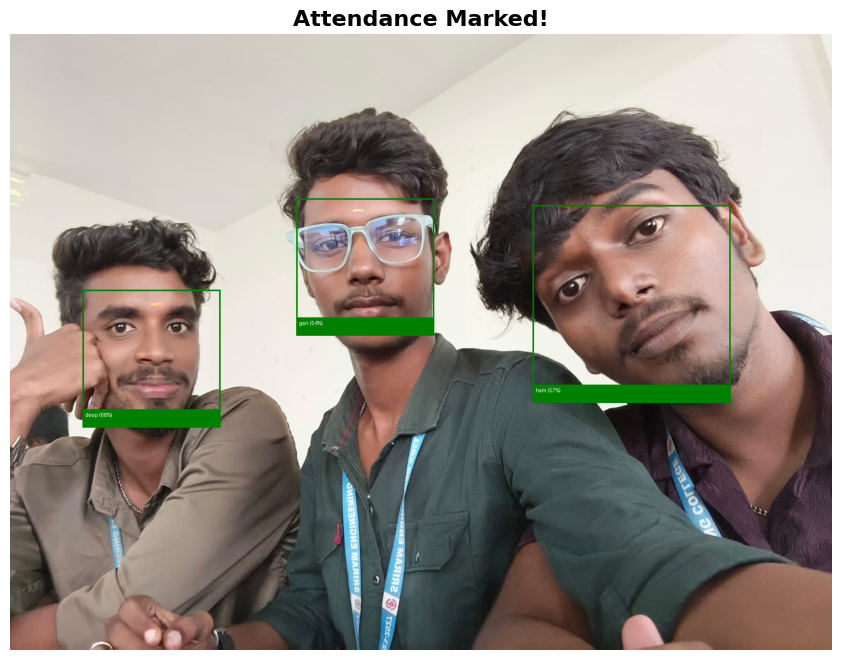


📋 Current Attendance Records:
   name              session        date      time            timestamp  \
0   gan  Morning_Class_Jan23  2026-01-22  11:26:56  2026-01-22 11:26:56   
1  deep  Morning_Class_Jan23  2026-01-22  11:26:56  2026-01-22 11:26:56   
2   ham  Morning_Class_Jan23  2026-01-22  11:26:56  2026-01-22 11:26:56   
3   gan  Morning_Class_Jan23  2026-01-22  11:57:59  2026-01-22 11:57:59   
4  deep  Morning_Class_Jan23  2026-01-22  11:57:59  2026-01-22 11:57:59   
5   ham  Morning_Class_Jan23  2026-01-22  11:57:59  2026-01-22 11:57:59   

  confidence                                         image_path  
0     54.08%  /content/drive/MyDrive/test_image/WhatsApp Ima...  
1     68.44%  /content/drive/MyDrive/test_image/WhatsApp Ima...  
2     57.14%  /content/drive/MyDrive/test_image/WhatsApp Ima...  
3     54.08%  /content/drive/MyDrive/test_image/WhatsApp Ima...  
4     68.44%  /content/drive/MyDrive/test_image/WhatsApp Ima...  
5     57.14%  /content/drive/MyDrive/test_image

In [38]:
# Cell 5: Test the attendance system

# Start a new session
session_name = attendance_system.start_session("Morning_Class_Jan23")

# Test recognition and attendance
test_image = "/content/drive/MyDrive/test_image/WhatsApp Image 2026-01-22 at 7.18.32 AM.jpeg"  # Change to your test image

results, annotated_img = attendance_system.recognize_and_mark(
    test_image,
    tolerance=0.5,
    mark_attendance_flag=True
)

# Display result
if annotated_img:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 8))
    plt.imshow(annotated_img)
    plt.axis('off')
    plt.title("Attendance Marked!", fontsize=16, fontweight='bold')
    plt.show()

# View attendance records
print("\n📋 Current Attendance Records:")
print(attendance_system.get_attendance_records())

# Get statistics
print("\n📊 Attendance Statistics:")
stats = attendance_system.get_attendance_stats()
for key, value in stats.items():
    print(f"   {key}: {value}")

In [39]:
# Cell 6: Create Streamlit App File

streamlit_code = """
import streamlit as st
import pandas as pd
import plotly.express as px
from datetime import datetime
import os
from PIL import Image
import sys

sys.path.append("/content")

st.set_page_config(
    page_title="Smart Attendance System",
    page_icon="🎓",
    layout="wide",
    initial_sidebar_state="expanded"
)

try:
    import __main__
    attendance_system = __main__.attendance_system
except Exception as e:
    st.error(f"⚠️ Attendance system not loaded: {e}")
    st.stop()

st.markdown(\"\"\"
    <style>
    .main-header {
        font-size: 2.5rem;
        font-weight: bold;
        text-align: center;
        padding: 1rem;
        background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
        color: white;
        border-radius: 10px;
        margin-bottom: 2rem;
    }
    </style>
\"\"\", unsafe_allow_html=True)

st.markdown('<div class="main-header">🎓 Smart Attendance System</div>', unsafe_allow_html=True)

with st.sidebar:
    st.title("📋 Navigation")
    page = st.radio("Select Page", ["🏠 Home", "✅ Mark Attendance", "📊 View Records", "📈 Analytics"])
    st.markdown("---")
    st.subheader("System Info")
    st.metric("Registered People", len(set(attendance_system.known_names)))
    st.metric("Training Images", len(attendance_system.known_faces))
    if attendance_system.current_session:
        st.info(f"📝 Session: {attendance_system.current_session}")

if page == "🏠 Home":
    st.header("Welcome! 👋")
    col1, col2 = st.columns(2)

    with col1:
        st.subheader("📋 Quick Stats")
        stats = attendance_system.get_attendance_stats()
        st.metric("📊 Total Records", stats['total_records'])
        st.metric("👥 Unique People", stats['unique_people'])
        st.metric("📅 Total Sessions", stats['total_sessions'])

    with col2:
        st.subheader("🎯 Features")
        st.markdown(\"\"\"
        ✅ Face Recognition
        ✅ Attendance Tracking
        ✅ Analytics & Reports
        ✅ Excel Export
        \"\"\")

    st.markdown("---")
    st.subheader("📋 Recent Attendance")
    df = attendance_system.get_attendance_records()
    if not df.empty:
        st.dataframe(df.tail(10), use_container_width=True)
    else:
        st.info("No attendance records yet!")

elif page == "✅ Mark Attendance":
    st.header("Mark Attendance 📸")

    col1, col2 = st.columns([2, 1])
    with col1:
        session_name = st.text_input("Session Name", value=datetime.now().strftime("%Y-%m-%d_%H-%M"))
    with col2:
        if st.button("🆕 Start New Session", use_container_width=True):
            attendance_system.start_session(session_name)
            st.success(f"✅ Started: {session_name}")
            st.rerun()

    if attendance_system.current_session:
        st.info(f"📝 Current: **{attendance_system.current_session}**")

    st.markdown("---")

    uploaded_file = st.file_uploader("Upload Image", type=['jpg', 'jpeg', 'png'])

    if uploaded_file:
        os.makedirs("/content/temp_uploads", exist_ok=True)
        temp_path = os.path.join("/content/temp_uploads", uploaded_file.name)
        with open(temp_path, "wb") as f:
            f.write(uploaded_file.getbuffer())

        col1, col2 = st.columns(2)
        with col1:
            st.subheader("📷 Original")
            st.image(uploaded_file, use_container_width=True)

        tolerance = st.slider("Sensitivity", 0.3, 0.7, 0.5, 0.05)
        mark_flag = st.checkbox("Mark Attendance", value=True)

        if st.button("🔍 Recognize Faces", type="primary", use_container_width=True):
            with st.spinner("Processing..."):
                results, annotated_img = attendance_system.recognize_and_mark(temp_path, tolerance, mark_flag)

                if results:
                    with col2:
                        st.subheader("✅ Result")
                        st.image(annotated_img, use_container_width=True)

                    st.markdown("---")
                    st.subheader("📋 Results")
                    for i, r in enumerate(results, 1):
                        if r['name'] != "Unknown":
                            status = "✅ Marked" if r['attendance_marked'] else f"⚠️ {r['message']}"
                            st.success(f"Person {i}: **{r['name']}** ({r['confidence']:.1f}%) - {status}")
                        else:
                            st.warning(f"Person {i}: Unknown")
                else:
                    st.warning("No faces detected!")

elif page == "📊 View Records":
    st.header("Attendance Records 📋")
    df = attendance_system.get_attendance_records()

    if df.empty:
        st.info("No records yet!")
    else:
        st.dataframe(df, use_container_width=True, hide_index=True)

        st.markdown("---")
        col1, col2 = st.columns(2)

        with col1:
            csv = df.to_csv(index=False).encode('utf-8')
            st.download_button("📄 Download CSV", csv, f"attendance_{datetime.now().strftime('%Y%m%d')}.csv", "text/csv", use_container_width=True)

        with col2:
            if st.button("📊 Generate Excel", use_container_width=True):
                success, result = attendance_system.export_to_excel()
                if success:
                    st.success(f"✅ Saved to Google Drive!")
                    st.info(f"📁 {result}")

elif page == "📈 Analytics":
    st.header("Analytics 📊")
    df = attendance_system.get_attendance_records()

    if df.empty:
        st.info("No data yet!")
    else:
        col1, col2, col3, col4 = st.columns(4)
        with col1:
            st.metric("📋 Total", len(df))
        with col2:
            st.metric("👥 People", df['name'].nunique())
        with col3:
            st.metric("📅 Days", df['date'].nunique())
        with col4:
            st.metric("📝 Sessions", df['session'].nunique())

        st.markdown("---")

        col1, col2 = st.columns(2)
        with col1:
            st.subheader("👥 By Person")
            person_counts = df['name'].value_counts().reset_index()
            person_counts.columns = ['Name', 'Count']
            fig1 = px.bar(person_counts, x='Name', y='Count', color='Count')
            st.plotly_chart(fig1, use_container_width=True)

        with col2:
            st.subheader("📅 Over Time")
            date_counts = df['date'].value_counts().sort_index().reset_index()
            date_counts.columns = ['Date', 'Count']
            fig2 = px.line(date_counts, x='Date', y='Count', markers=True)
            st.plotly_chart(fig2, use_container_width=True)

st.markdown("---")
st.markdown("<div style='text-align: center; color: gray;'>Made with ❤️</div>", unsafe_allow_html=True)
"""

with open("/content/attendance_app.py", "w") as f:
    f.write(streamlit_code)

print("✅ Streamlit app created: /content/attendance_app.py")
print("✅ Ready to launch!")

✅ Streamlit app created: /content/attendance_app.py
✅ Ready to launch!


In [40]:
# Cell: Launch with Ngrok (NO PASSWORD NEEDED!)

# Stop current streamlit
!pkill -f streamlit

# Install ngrok
!pip install -q pyngrok

from pyngrok import ngrok
import subprocess
import time

# Set your ngrok token (get from https://dashboard.ngrok.com/get-started/your-authtoken)
ngrok.set_auth_token("38bxVMa41QtJnhTjABAqU2W3dqJ_7i3niYUAoxP1DmBUYFALC")  # Replace with your actual token

# Start streamlit
print("🚀 Starting Streamlit...")
subprocess.Popen(["streamlit", "run", "/content/attendance_app.py", "--server.port", "8501"])

# Wait for startup
time.sleep(10)

# Create public URL
public_url = ngrok.connect(8501)

print("="*60)
print("🎉 DASHBOARD IS LIVE!")
print("="*60)
print(f"🌐 URL: {public_url}")
print("\n📱 Click the URL above - NO PASSWORD NEEDED!")
print("="*60)



🚀 Starting Streamlit...
🎉 DASHBOARD IS LIVE!
🌐 URL: NgrokTunnel: "https://reportable-lillianna-seamiest.ngrok-free.dev" -> "http://localhost:8501"

📱 Click the URL above - NO PASSWORD NEEDED!


In [41]:
# Cell: Stop everything
!pkill -f streamlit
!pkill -f ngrok

print("✅ Stopped all processes")

✅ Stopped all processes


In [42]:
# Cell: Verify system is loaded

# Check if attendance_system exists
try:
    print("🔍 Checking attendance system...")
    print(f"✅ System exists: {type(attendance_system)}")
    print(f"✅ People loaded: {len(set(attendance_system.known_names))}")
    print(f"✅ Training images: {len(attendance_system.known_faces)}")
    print("\n✅ System is ready!")
except NameError:
    print("❌ System not found! Running Cell 2 and Cell 3 now...")
    # If not loaded, we'll reload it in next cell

🔍 Checking attendance system...
✅ System exists: <class '__main__.AttendanceSystem'>
✅ People loaded: 5
✅ Training images: 17

✅ System is ready!


In [43]:
# Cell 6: Create Fixed Streamlit App with Pickle

import pickle
import os

# Save the attendance system to a file so Streamlit can load it
print("💾 Saving attendance system state...")

# Create directory
os.makedirs("/content/app_data", exist_ok=True)

# Save the system
with open("/content/app_data/attendance_system.pkl", "wb") as f:
    pickle.dump(attendance_system, f)

print("✅ System state saved!")

# Now create the Streamlit app
streamlit_code = """
import streamlit as st
import pandas as pd
import plotly.express as px
from datetime import datetime
import os
from PIL import Image
import pickle

st.set_page_config(
    page_title="Smart Attendance System",
    page_icon="🎓",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Load the attendance system from saved file
@st.cache_resource
def load_system():
    try:
        with open("/content/app_data/attendance_system.pkl", "rb") as f:
            system = pickle.load(f)
        return system
    except Exception as e:
        st.error(f"Error loading system: {e}")
        return None

attendance_system = load_system()

if attendance_system is None:
    st.error("⚠️ Failed to load attendance system!")
    st.error("Please run Cell 2 and Cell 3 in Colab first, then Cell 6 again.")
    st.stop()

# Custom CSS
st.markdown(\"\"\"
    <style>
    .main-header {
        font-size: 2.5rem;
        font-weight: bold;
        text-align: center;
        padding: 1rem;
        background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
        color: white;
        border-radius: 10px;
        margin-bottom: 2rem;
    }
    </style>
\"\"\", unsafe_allow_html=True)

st.markdown('<div class="main-header">🎓 Smart Attendance System</div>', unsafe_allow_html=True)

# Sidebar
with st.sidebar:
    st.title("📋 Navigation")
    page = st.radio("Select Page", ["🏠 Home", "✅ Mark Attendance", "📊 View Records", "📈 Analytics"])
    st.markdown("---")
    st.subheader("System Info")
    st.metric("Registered People", len(set(attendance_system.known_names)))
    st.metric("Training Images", len(attendance_system.known_faces))
    if attendance_system.current_session:
        st.info(f"📝 Session: {attendance_system.current_session}")

# HOME PAGE
if page == "🏠 Home":
    st.header("Welcome to Smart Attendance System! 👋")

    col1, col2 = st.columns(2)

    with col1:
        st.subheader("📋 Quick Stats")
        stats = attendance_system.get_attendance_stats()
        st.metric("📊 Total Records", stats['total_records'])
        st.metric("👥 Unique People", stats['unique_people'])
        st.metric("📅 Total Sessions", stats['total_sessions'])

    with col2:
        st.subheader("🎯 Features")
        st.markdown(\"\"\"
        ✅ **Face Recognition**
        ✅ **Attendance Tracking**
        ✅ **Analytics & Reports**
        ✅ **Excel Export**
        \"\"\")

    st.markdown("---")
    st.subheader("📋 Recent Attendance")
    df = attendance_system.get_attendance_records()
    if not df.empty:
        st.dataframe(df.tail(10), use_container_width=True)
    else:
        st.info("No attendance records yet!")

    # Show registered people
    st.subheader("👥 Registered People")
    if attendance_system.known_names:
        people = list(set(attendance_system.known_names))
        cols = st.columns(min(len(people), 4))
        for idx, person in enumerate(people):
            with cols[idx % 4]:
                st.success(f"👤 {person}")
    else:
        st.warning("No people registered!")

# MARK ATTENDANCE PAGE
elif page == "✅ Mark Attendance":
    st.header("Mark Attendance 📸")

    col1, col2 = st.columns([2, 1])
    with col1:
        session_name = st.text_input("Session Name", value=datetime.now().strftime("%Y-%m-%d_%H-%M"))
    with col2:
        if st.button("🆕 Start New Session", use_container_width=True):
            attendance_system.start_session(session_name)
            # Save updated system
            with open("/content/app_data/attendance_system.pkl", "wb") as f:
                pickle.dump(attendance_system, f)
            st.success(f"✅ Started: {session_name}")
            st.rerun()

    if attendance_system.current_session:
        st.info(f"📝 Current Session: **{attendance_system.current_session}**")
        st.info(f"👥 Already Marked: **{len(attendance_system.session_attendees)}** people")

    st.markdown("---")

    uploaded_file = st.file_uploader("Upload Image", type=['jpg', 'jpeg', 'png'])

    if uploaded_file:
        os.makedirs("/content/temp_uploads", exist_ok=True)
        temp_path = os.path.join("/content/temp_uploads", uploaded_file.name)
        with open(temp_path, "wb") as f:
            f.write(uploaded_file.getbuffer())

        col1, col2 = st.columns(2)
        with col1:
            st.subheader("📷 Original")
            st.image(uploaded_file, use_container_width=True)

        tolerance = st.slider("Sensitivity", 0.3, 0.7, 0.5, 0.05)
        mark_flag = st.checkbox("Mark Attendance", value=True)

        if st.button("🔍 Recognize Faces", type="primary", use_container_width=True):
            with st.spinner("Processing..."):
                results, annotated_img = attendance_system.recognize_and_mark(temp_path, tolerance, mark_flag)

                # Save updated system
                with open("/content/app_data/attendance_system.pkl", "wb") as f:
                    pickle.dump(attendance_system, f)

                if results:
                    with col2:
                        st.subheader("✅ Result")
                        st.image(annotated_img, use_container_width=True)

                    st.markdown("---")
                    st.subheader("📋 Results")
                    for i, r in enumerate(results, 1):
                        if r['name'] != "Unknown":
                            status = "✅ Marked" if r['attendance_marked'] else f"⚠️ {r['message']}"
                            st.success(f"Person {i}: **{r['name']}** ({r['confidence']:.1f}%) - {status}")
                        else:
                            st.warning(f"Person {i}: Unknown")
                else:
                    st.warning("No faces detected!")

# VIEW RECORDS PAGE
elif page == "📊 View Records":
    st.header("Attendance Records 📋")
    df = attendance_system.get_attendance_records()

    if df.empty:
        st.info("No records yet!")
    else:
        st.dataframe(df, use_container_width=True, hide_index=True)

        st.markdown("---")
        col1, col2 = st.columns(2)

        with col1:
            csv = df.to_csv(index=False).encode('utf-8')
            st.download_button("📄 Download CSV", csv, f"attendance_{datetime.now().strftime('%Y%m%d')}.csv", "text/csv", use_container_width=True)

        with col2:
            if st.button("📊 Generate Excel", use_container_width=True):
                success, result = attendance_system.export_to_excel()
                if success:
                    st.success("✅ Saved to Google Drive!")
                    st.info(f"📁 {result}")

# ANALYTICS PAGE
elif page == "📈 Analytics":
    st.header("Analytics Dashboard 📊")
    df = attendance_system.get_attendance_records()

    if df.empty:
        st.info("No data yet!")
    else:
        col1, col2, col3, col4 = st.columns(4)
        with col1:
            st.metric("📋 Total", len(df))
        with col2:
            st.metric("👥 People", df['name'].nunique())
        with col3:
            st.metric("📅 Days", df['date'].nunique())
        with col4:
            st.metric("📝 Sessions", df['session'].nunique())

        st.markdown("---")

        col1, col2 = st.columns(2)
        with col1:
            st.subheader("👥 By Person")
            person_counts = df['name'].value_counts().reset_index()
            person_counts.columns = ['Name', 'Count']
            fig1 = px.bar(person_counts, x='Name', y='Count', color='Count', color_continuous_scale='Blues')
            st.plotly_chart(fig1, use_container_width=True)

        with col2:
            st.subheader("📅 Over Time")
            date_counts = df['date'].value_counts().sort_index().reset_index()
            date_counts.columns = ['Date', 'Count']
            fig2 = px.line(date_counts, x='Date', y='Count', markers=True)
            st.plotly_chart(fig2, use_container_width=True)

st.markdown("---")
st.markdown("<div style='text-align: center; color: gray;'>Made with ❤️ by You</div>", unsafe_allow_html=True)
"""

# Save the app
with open("/content/attendance_app.py", "w") as f:
    f.write(streamlit_code)

print("✅ Fixed Streamlit app created!")
print("✅ System state saved to: /content/app_data/attendance_system.pkl")
print("\n📝 Next: Run Cell 7 to launch the dashboard")

💾 Saving attendance system state...
✅ System state saved!
✅ Fixed Streamlit app created!
✅ System state saved to: /content/app_data/attendance_system.pkl

📝 Next: Run Cell 7 to launch the dashboard


In [44]:
# Cell 7: Launch Fixed Dashboard

!pip install -q pyngrok

from pyngrok import ngrok
import subprocess
import time

# Kill existing
!pkill -f streamlit

# Set your ngrok token (get from https://dashboard.ngrok.com/get-started/your-authtoken)
ngrok.set_auth_token("38bxVMa41QtJnhTjABAqU2W3dqJ_7i3niYUAoxP1DmBUYFALC")  # Replace with your token

# Start Streamlit
print("🚀 Starting Streamlit...")
subprocess.Popen(["streamlit", "run", "/content/attendance_app.py", "--server.port", "8501"])

# Wait
time.sleep(10)

# Create tunnel
public_url = ngrok.connect(8501)

print("="*60)
print("🎉 DASHBOARD IS LIVE!")
print("="*60)
print(f"🌐 URL: {public_url}")
print("\n✅ No password needed!")
print("✅ Click the URL above to open dashboard")
print("="*60)

🚀 Starting Streamlit...
🎉 DASHBOARD IS LIVE!
🌐 URL: NgrokTunnel: "https://reportable-lillianna-seamiest.ngrok-free.dev" -> "http://localhost:8501"

✅ No password needed!
✅ Click the URL above to open dashboard


In [45]:
# Cell: Clean start
!pkill -f streamlit
!pkill -f ngrok

# Remove old files
!rm -rf /content/app_data
!rm -f /content/attendance_app.py

print("✅ Cleaned up old files")

✅ Cleaned up old files


In [46]:
# Cell: Check if system is loaded

try:
    print("🔍 Checking attendance system...")
    print(f"✅ Type: {type(attendance_system)}")
    print(f"✅ People: {len(set(attendance_system.known_names))}")
    print(f"✅ Images: {len(attendance_system.known_faces)}")

    if len(attendance_system.known_faces) == 0:
        print("\n⚠️ WARNING: No training data loaded!")
        print("Run the load_training_data() cell")
    else:
        print("\n✅ System is ready!")

except NameError:
    print("❌ attendance_system NOT FOUND!")
    print("\n📝 You need to run these cells first:")
    print("   1. Cell 2 - Create AttendanceSystem")
    print("   2. Cell 3 - Load training data")
    print("\nRun them now, then come back to this cell")

🔍 Checking attendance system...
✅ Type: <class '__main__.AttendanceSystem'>
✅ People: 5
✅ Images: 17

✅ System is ready!


In [47]:
# Cell: Save system and create app

import pickle
import os

# Create directory
os.makedirs("/content/app_data", exist_ok=True)

# Save the attendance system
print("💾 Saving attendance system...")
try:
    with open("/content/app_data/attendance_system.pkl", "wb") as f:
        pickle.dump(attendance_system, f)
    print("✅ System saved successfully!")
    print(f"✅ File created: /content/app_data/attendance_system.pkl")

    # Verify it was saved
    file_size = os.path.getsize("/content/app_data/attendance_system.pkl")
    print(f"✅ File size: {file_size} bytes")

except Exception as e:
    print(f"❌ Error saving system: {e}")
    print("Make sure attendance_system is loaded (run Cell 2 & 3)")

print("\n" + "="*60)
print("📝 Creating Streamlit app...")

# Create the streamlit app
streamlit_code = """
import streamlit as st
import pandas as pd
import plotly.express as px
from datetime import datetime
import os
from PIL import Image
import pickle
import sys

st.set_page_config(
    page_title="Smart Attendance System",
    page_icon="🎓",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Load system
@st.cache_resource
def load_system():
    pkl_file = "/content/app_data/attendance_system.pkl"

    if not os.path.exists(pkl_file):
        st.error(f"❌ File not found: {pkl_file}")
        st.error("Please run Cell 2, Cell 3, and the save cell in Colab first!")
        return None

    try:
        with open(pkl_file, "rb") as f:
            system = pickle.load(f)
        st.success(f"✅ System loaded! {len(set(system.known_names))} people registered")
        return system
    except Exception as e:
        st.error(f"❌ Error loading: {e}")
        return None

attendance_system = load_system()

if attendance_system is None:
    st.stop()

# Header
st.markdown(\"\"\"
    <div style='font-size: 2.5rem; font-weight: bold; text-align: center; padding: 1rem;
    background: linear-gradient(90deg, #667eea 0%, #764ba2 100%); color: white;
    border-radius: 10px; margin-bottom: 2rem;'>
    🎓 Smart Attendance System
    </div>
\"\"\", unsafe_allow_html=True)

# Sidebar
with st.sidebar:
    st.title("📋 Navigation")
    page = st.radio("Select Page", ["🏠 Home", "✅ Mark Attendance", "📊 View Records", "📈 Analytics"])
    st.markdown("---")
    st.metric("👥 Registered", len(set(attendance_system.known_names)))
    st.metric("📸 Images", len(attendance_system.known_faces))

# HOME
if page == "🏠 Home":
    st.header("Welcome! 👋")

    col1, col2 = st.columns(2)
    with col1:
        st.subheader("📊 Stats")
        stats = attendance_system.get_attendance_stats()
        st.metric("Total Records", stats['total_records'])
        st.metric("Unique People", stats['unique_people'])
        st.metric("Sessions", stats['total_sessions'])

    with col2:
        st.subheader("👥 Registered People")
        people = list(set(attendance_system.known_names))
        for person in people:
            st.info(f"✅ {person}")

    st.markdown("---")
    df = attendance_system.get_attendance_records()
    if not df.empty:
        st.subheader("📋 Recent Records")
        st.dataframe(df.tail(10), use_container_width=True)

# MARK ATTENDANCE
elif page == "✅ Mark Attendance":
    st.header("Mark Attendance 📸")

    col1, col2 = st.columns([2, 1])
    with col1:
        session = st.text_input("Session", datetime.now().strftime("%Y-%m-%d_%H-%M"))
    with col2:
        if st.button("Start Session"):
            attendance_system.start_session(session)
            with open("/content/app_data/attendance_system.pkl", "wb") as f:
                pickle.dump(attendance_system, f)
            st.success(f"Started: {session}")

    uploaded = st.file_uploader("Upload Image", type=['jpg', 'jpeg', 'png'])

    if uploaded:
        os.makedirs("/content/temp", exist_ok=True)
        path = f"/content/temp/{uploaded.name}"
        with open(path, "wb") as f:
            f.write(uploaded.getbuffer())

        col1, col2 = st.columns(2)
        with col1:
            st.image(uploaded, caption="Original", use_container_width=True)

        if st.button("🔍 Recognize", type="primary"):
            with st.spinner("Processing..."):
                results, img = attendance_system.recognize_and_mark(path, 0.5, True)
                with open("/content/app_data/attendance_system.pkl", "wb") as f:
                    pickle.dump(attendance_system, f)

                if results:
                    with col2:
                        st.image(img, caption="Result", use_container_width=True)

                    for i, r in enumerate(results, 1):
                        if r['name'] != "Unknown":
                            st.success(f"{r['name']} - {r['confidence']:.1f}%")
                        else:
                            st.warning("Unknown person")

# VIEW RECORDS
elif page == "📊 View Records":
    st.header("Records 📋")
    df = attendance_system.get_attendance_records()

    if not df.empty:
        st.dataframe(df, use_container_width=True)
        csv = df.to_csv(index=False).encode()
        st.download_button("📥 Download CSV", csv, "attendance.csv", "text/csv")
    else:
        st.info("No records yet!")

# ANALYTICS
elif page == "📈 Analytics":
    st.header("Analytics 📊")
    df = attendance_system.get_attendance_records()

    if not df.empty:
        col1, col2, col3 = st.columns(3)
        col1.metric("Total", len(df))
        col2.metric("People", df['name'].nunique())
        col3.metric("Days", df['date'].nunique())

        st.subheader("Attendance by Person")
        counts = df['name'].value_counts().reset_index()
        counts.columns = ['Name', 'Count']
        fig = px.bar(counts, x='Name', y='Count', color='Count')
        st.plotly_chart(fig, use_container_width=True)
    else:
        st.info("No data yet!")
"""

with open("/content/attendance_app.py", "w") as f:
    f.write(streamlit_code)

print("✅ Streamlit app created!")
print("✅ File: /content/attendance_app.py")
print("\n" + "="*60)
print("✅ Ready to launch!")
print("📝 Next: Run the launch cell with your ngrok token")

💾 Saving attendance system...
✅ System saved successfully!
✅ File created: /content/app_data/attendance_system.pkl
✅ File size: 18375 bytes

📝 Creating Streamlit app...
✅ Streamlit app created!
✅ File: /content/attendance_app.py

✅ Ready to launch!
📝 Next: Run the launch cell with your ngrok token


In [48]:
# Cell: Launch Dashboard

!pip install -q pyngrok

from pyngrok import ngrok
import subprocess
import time

# Stop existing
!pkill -f streamlit

# YOUR NGROK TOKEN HERE (get from https://dashboard.ngrok.com/get-started/your-authtoken)
NGROK_TOKEN = "38bxVMa41QtJnhTjABAqU2W3dqJ_7i3niYUAoxP1DmBUYFALC"  # ⚠️ REPLACE THIS!

if NGROK_TOKEN == "YOUR_TOKEN_HERE":
    print("⚠️  Please add your ngrok token!")
    print("Get it from: https://dashboard.ngrok.com/get-started/your-authtoken")
else:
    ngrok.set_auth_token(NGROK_TOKEN)

    # Start streamlit
    print("🚀 Starting Streamlit...")
    subprocess.Popen(["streamlit", "run", "/content/attendance_app.py", "--server.port", "8501"])

    time.sleep(10)

    # Create tunnel
    public_url = ngrok.connect(8501)

    print("="*60)
    print("🎉 SUCCESS!")
    print("="*60)
    print(f"🌐 URL: {public_url}")
    print("\n✅ Click the URL above!")
    print("="*60)

🚀 Starting Streamlit...
🎉 SUCCESS!
🌐 URL: NgrokTunnel: "https://reportable-lillianna-seamiest.ngrok-free.dev" -> "http://localhost:8501"

✅ Click the URL above!


In [49]:
# Cell: Stop all
!pkill -f streamlit
!pkill -f ngrok
print("✅ Stopped")

✅ Stopped


In [57]:
# Cell: Create Standalone Streamlit App

streamlit_code = '''
import streamlit as st
import pandas as pd
import plotly.express as px
from datetime import datetime
import os
from PIL import Image, ImageDraw
import face_recognition
import numpy as np

st.set_page_config(
    page_title="Smart Attendance System",
    page_icon="🎓",
    layout="wide"
)

# Define the AttendanceSystem class inside Streamlit
class AttendanceSystem:
    def __init__(self, dataset_path="/content/drive/MyDrive/dataset",
                 attendance_path="/content/drive/MyDrive/attendance_records"):
        self.dataset_path = dataset_path
        self.attendance_path = attendance_path
        self.known_faces = []
        self.known_names = []
        self.current_session = None
        self.session_attendees = set()
        os.makedirs(attendance_path, exist_ok=True)

    def load_training_data(self):
        if not os.path.exists(self.dataset_path):
            return False

        for person_name in os.listdir(self.dataset_path):
            person_folder = os.path.join(self.dataset_path, person_name)
            if not os.path.isdir(person_folder):
                continue

            for image_file in os.listdir(person_folder):
                if not image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue

                image_path = os.path.join(person_folder, image_file)
                try:
                    img = face_recognition.load_image_file(image_path)
                    encodings = face_recognition.face_encodings(img)
                    if len(encodings) > 0:
                        self.known_faces.append(encodings[0])
                        self.known_names.append(person_name)
                except:
                    pass

        return len(self.known_faces) > 0

    def start_session(self, session_name=None):
        if session_name is None:
            session_name = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        self.current_session = session_name
        self.session_attendees = set()
        return session_name

    def mark_attendance(self, name, confidence):
        if self.current_session is None:
            self.start_session()

        if name in self.session_attendees:
            return False, "Already marked"

        timestamp = datetime.now()
        record = {
            "name": name,
            "session": self.current_session,
            "date": timestamp.strftime("%Y-%m-%d"),
            "time": timestamp.strftime("%H:%M:%S"),
            "timestamp": timestamp.strftime("%Y-%m-%d %H:%M:%S"),
            "confidence": f"{confidence:.2f}%"
        }

        csv_file = os.path.join(self.attendance_path, "attendance.csv")
        df = pd.DataFrame([record])

        if os.path.exists(csv_file):
            df.to_csv(csv_file, mode='a', header=False, index=False)
        else:
            df.to_csv(csv_file, index=False)

        self.session_attendees.add(name)
        return True, "Marked"

    def recognize_and_mark(self, image_path, tolerance=0.5, mark=True):
        test_img = face_recognition.load_image_file(image_path)
        face_locations = face_recognition.face_locations(test_img)
        face_encodings = face_recognition.face_encodings(test_img, face_locations)

        if len(face_locations) == 0:
            return [], None

        pil_img = Image.fromarray(test_img)
        draw = ImageDraw.Draw(pil_img)
        results = []

        for face_location, face_encoding in zip(face_locations, face_encodings):
            matches = face_recognition.compare_faces(self.known_faces, face_encoding, tolerance)
            distances = face_recognition.face_distance(self.known_faces, face_encoding)

            name = "Unknown"
            confidence = 0

            if len(distances) > 0 and True in matches:
                best_idx = np.argmin(distances)
                if matches[best_idx]:
                    name = self.known_names[best_idx]
                    confidence = (1 - distances[best_idx]) * 100

            top, right, bottom, left = face_location
            color = "green" if name != "Unknown" else "red"
            draw.rectangle([(left, top), (right, bottom)], outline=color, width=3)
            draw.rectangle([(left, bottom-35), (right, bottom)], fill=color)

            text = f"{name} ({confidence:.0f}%)" if name != "Unknown" else "Unknown"
            draw.text((left+6, bottom-30), text, fill="white")

            marked = False
            msg = ""
            if mark and name != "Unknown":
                marked, msg = self.mark_attendance(name, confidence)

            results.append({
                "name": name,
                "confidence": confidence,
                "marked": marked,
                "message": msg
            })

        return results, pil_img

    def get_attendance_records(self):
        csv_file = os.path.join(self.attendance_path, "attendance.csv")
        if os.path.exists(csv_file):
            return pd.read_csv(csv_file)
        return pd.DataFrame()

# Initialize system
@st.cache_resource
def init_system():
    system = AttendanceSystem()
    if system.load_training_data():
        return system
    return None

system = init_system()

# UI
st.markdown("""
<div style='font-size: 2.5rem; font-weight: bold; text-align: center;
padding: 1rem; background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
color: white; border-radius: 10px; margin-bottom: 2rem;'>
🎓 Smart Attendance System
</div>
""", unsafe_allow_html=True)

if system is None:
    st.error("❌ Failed to load training data!")
    st.error("Check: /content/drive/MyDrive/dataset/")
    st.stop()

# Sidebar
with st.sidebar:
    st.title("📋 Navigation")
    page = st.radio("Go to", ["🏠 Home", "✅ Mark Attendance", "📊 Records", "📈 Analytics"])
    st.markdown("---")
    st.metric("👥 People", len(set(system.known_names)))
    st.metric("📸 Images", len(system.known_faces))

# HOME
if page == "🏠 Home":
    st.header("Welcome! 👋")

    col1, col2 = st.columns(2)
    with col1:
        st.subheader("👥 Registered People")
        people = list(set(system.known_names))
        for p in people:
            st.success(f"✅ {p}")

    with col2:
        st.subheader("📊 Quick Stats")
        df = system.get_attendance_records()
        st.metric("Total Records", len(df))
        st.metric("Unique People", df['name'].nunique() if not df.empty else 0)

# MARK ATTENDANCE
elif page == "✅ Mark Attendance":
    st.header("Mark Attendance 📸")

    session = st.text_input("Session Name", datetime.now().strftime("%Y-%m-%d_%H-%M"))
    if st.button("Start New Session"):
        system.start_session(session)
        st.success(f"✅ Started: {session}")

    uploaded = st.file_uploader("Upload Image", type=['jpg','jpeg','png'])

    if uploaded:
        os.makedirs("/content/temp", exist_ok=True)
        path = f"/content/temp/{uploaded.name}"
        with open(path, "wb") as f:
            f.write(uploaded.getbuffer())

        col1, col2 = st.columns(2)
        with col1:
            st.image(uploaded, caption="Original", use_container_width=True)

        if st.button("🔍 Recognize Faces", type="primary"):
            with st.spinner("Processing..."):
                results, img = system.recognize_and_mark(path, 0.5, True)

                if results:
                    with col2:
                        st.image(img, caption="Result", use_container_width=True)

                    st.markdown("---")
                    for i, r in enumerate(results, 1):
                        if r['name'] != "Unknown":
                            status = "✅ Marked" if r['marked'] else f"⚠️ {r['message']}"
                            st.success(f"Person {i}: **{r['name']}** ({r['confidence']:.1f}%) - {status}")
                        else:
                            st.warning(f"Person {i}: Unknown")
                else:
                    st.warning("No faces detected!")

# RECORDS
elif page == "📊 Records":
    st.header("Attendance Records 📋")
    df = system.get_attendance_records()

    if not df.empty:
        st.dataframe(df, use_container_width=True)
        csv = df.to_csv(index=False).encode()
        st.download_button("📥 Download CSV", csv, "attendance.csv", "text/csv")
    else:
        st.info("No records yet!")

# ANALYTICS
elif page == "📈 Analytics":
    st.header("Analytics 📊")
    df = system.get_attendance_records()

    if not df.empty:
        col1, col2, col3 = st.columns(3)
        col1.metric("Total", len(df))
        col2.metric("People", df['name'].nunique())
        col3.metric("Days", df['date'].nunique())

        st.subheader("Attendance by Person")
        counts = df['name'].value_counts().reset_index()
        counts.columns = ['Name', 'Count']
        fig = px.bar(counts, x='Name', y='Count', color='Count')
        st.plotly_chart(fig, use_container_width=True)
    else:
        st.info("No data yet!")
'''

with open("/content/attendance_app.py", "w") as f:
    f.write(streamlit_code)

print("✅ Streamlit app created!")
print("✅ File: /content/attendance_app.py")
print("\n" + "="*60)
print("✅ Ready to launch!")
print("📝 Next: Run the launch cell with your ngrok token")

✅ Streamlit app created!
✅ File: /content/attendance_app.py

✅ Ready to launch!
📝 Next: Run the launch cell with your ngrok token


In [59]:
# Cell: Launch

!pip install -q pyngrok

from pyngrok import ngrok
import subprocess
import time

!pkill -f streamlit

# Add your ngrok token
NGROK_TOKEN = "38bxVMa41QtJnhTjABAqU2W3dqJ_7i3niYUAoxP1DmBUYFALC"  # ⚠️ Replace this

if NGROK_TOKEN == "NGROK_TOKEN":
    print("⚠️ Add your ngrok token!")
    print("Get it: https://dashboard.ngrok.com/get-started/your-authtoken")
else:
    ngrok.set_auth_token(NGROK_TOKEN)

    print("🚀 Starting...")
    subprocess.Popen(["streamlit", "run", "/content/attendance_app.py", "--server.port", "8501"])
    time.sleep(10)

    url = ngrok.connect(8501)

    print("="*60)
    print("✅ LIVE!")
    print("="*60)
    print(f"🌐 {url}")
    print("="*60)

🚀 Starting...
✅ LIVE!
🌐 NgrokTunnel: "https://reportable-lillianna-seamiest.ngrok-free.dev" -> "http://localhost:8501"
